In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import collections
import pandas as pd

from river import tree
from river import metrics
from river import compose
from river import preprocessing

from source.stability_analyzer import StabilityAnalyzer
from source.health_risk_dataset import HealthRiskDataset

In [13]:
dataset = HealthRiskDataset()

Let's take a look at the first sample.

In [14]:
x, y = next(iter(dataset))
x

{'Age': 25,
 'SystolicBP': 130,
 'DiastolicBP': 80,
 'BS': 15.0,
 'BodyTemp': 98.0,
 'HeartRate': 86}

In [15]:
y

'high risk'

In [16]:
counts = collections.Counter(y for _, y in dataset)
dataset_size = 0
for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')
    dataset_size += count

print('Dataset size: ', dataset_size)

high risk: 272 (26.82446%)
low risk: 406 (40.03945%)
mid risk: 336 (33.13609%)
Dataset size:  1014


In [17]:
# Creating a data frame
df = pd.read_csv("../datasets/Maternal-Health-Risk-Data-Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [18]:
df.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [19]:
def get_base_model():
    TARGET_COLUMN = 'RiskLevel'
    features = [feature for feature in df.columns if feature != TARGET_COLUMN]

    transform_pipeline = compose.Select(features[0])
    for feature in features[1:]:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.MinMaxScaler()

    return transform_pipeline | tree.HoeffdingTreeClassifier(grace_period=50, delta=0.01)

In [20]:
base_model = get_base_model()
label_mapping = {
    'high risk': 1,
    'mid risk': 1,
    'low risk': 0,
}
measure_every = 200
dataset_limit = None

In [21]:
def pretrain_model(base_model, dataset, label_mapping, train_fraction):
    # Conduct model pre-training
    train_size = int(dataset_size * train_fraction)
    acc_metric = metrics.Accuracy()
    f1_metric = metrics.WeightedF1()
    for idx, (x, y_true) in enumerate(dataset):
        y_true = label_mapping[y_true]
        y_pred = base_model.predict_one(x)

        # Update the error metric
        if y_pred is not None:
            acc_metric = acc_metric.update(y_true, y_pred)
            f1_metric = f1_metric.update(y_true, y_pred)

        base_model.learn_one(x=x, y=y_true)
        if idx + 1 == train_size:
            break

    print('Metrics for pre-trained model:')
    print(acc_metric)
    print(f1_metric)

    return base_model, dataset


def test_model(dataset, stability_analyzer, label_mapping, dataset_limit=None):
    # Test the model
    for idx, (x, y_true) in enumerate(dataset):
        y_true = label_mapping[y_true]
        stability_analyzer.measure_stability_metrics(x, y_true)

        # Shrink the dataset if needed
        if dataset_limit is not None and (idx + 1) == dataset_limit:
            break

In [22]:
base_model, dataset = pretrain_model(base_model, dataset, label_mapping, train_fraction=0.5)

Metrics for pre-trained model:
Accuracy: 73.72%
WeightedF1: 73.50%


In [23]:
stability_analyzer = StabilityAnalyzer(base_model, batch_size=measure_every)
test_model(dataset, stability_analyzer, label_mapping, dataset_limit)

Sample number: 200
Accuracy: 0.7487437185929648
Mean: 0.6030150753768844
Std: 0.0
IQR: 0.0
Per sample accuracy: 0.7487437185929648
Label stability: 1.0


Sample number: 400
Accuracy: 0.8542713567839196
Mean: 0.44120603015075377
Std: 0.16555124488735637
IQR: 0.13316582914572864
Per sample accuracy: 0.7969849246231157
Label stability: 0.8291457286432161


Sample number: 600
Accuracy: 0.7185929648241206
Mean: 0.5221105527638191
Std: 0.17457530098979193
IQR: 0.15829145728643215
Per sample accuracy: 0.6869346733668342
Label stability: 0.7899497487437185


Sample number: 800
Accuracy: 0.7236180904522613
Mean: 0.5748743718592965
Std: 0.21645515606318444
IQR: 0.17587939698492464
Per sample accuracy: 0.7447236180904522
Label stability: 0.7547738693467336


Sample number: 1000
Accuracy: 0.7135678391959799
Mean: 0.7819095477386935
Std: 0.19890895142924653
IQR: 0.2022613065326633
Per sample accuracy: 0.7085427135678392
Label stability: 0.7608040201005024




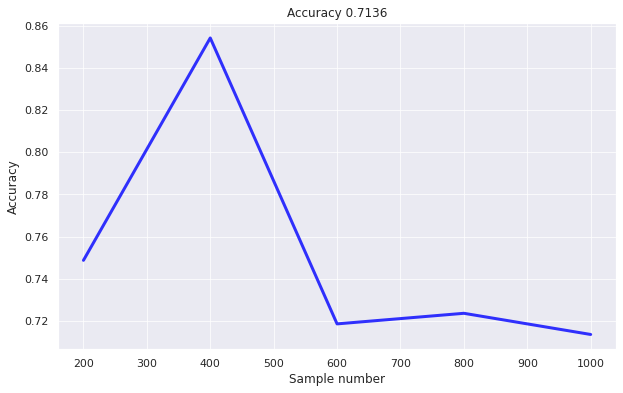

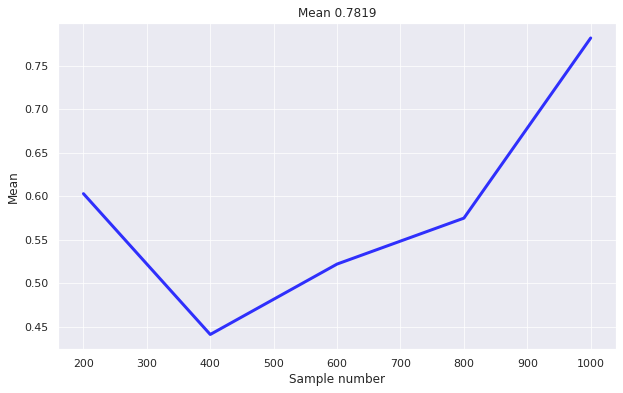

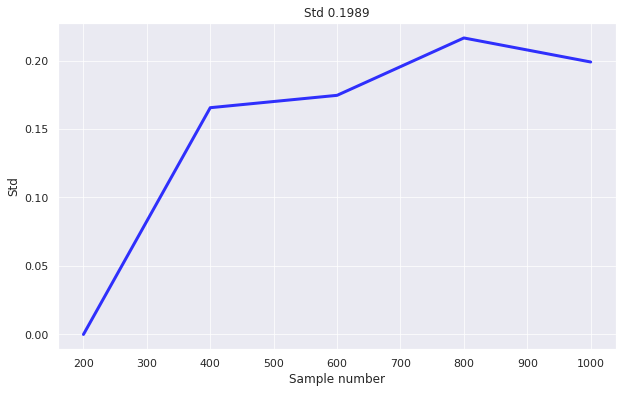

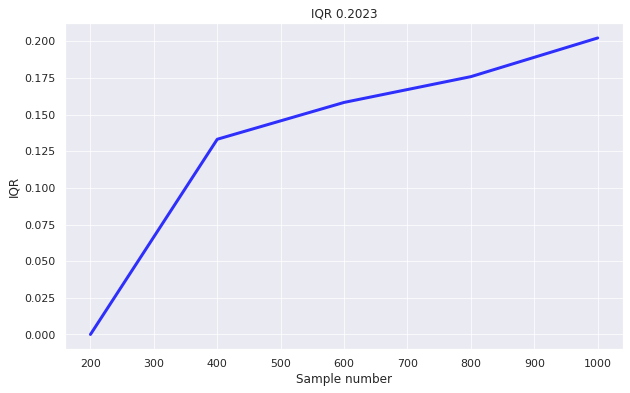

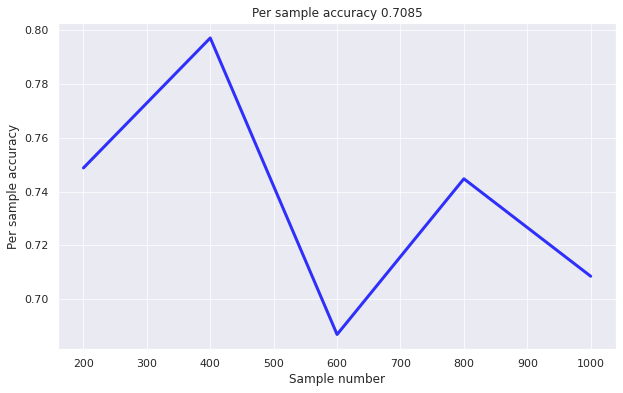

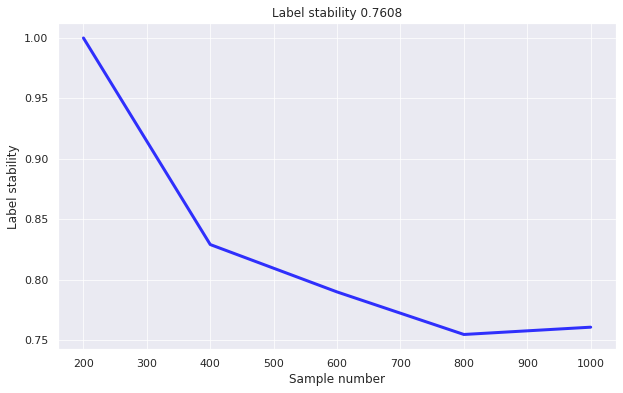

In [24]:
stability_analyzer.plot_metrics_history()

## Predict with HoeffdingTreeClassifier

In [92]:
from source.utils.river_utils import evaluate_binary_model

# model = compose.Pipeline(
#     preprocessing.StandardScaler(),
#     get_base_model()
# )
model = get_base_model()
model

Pipeline (
  TransformerUnion (
    Select (
      Age
    ),
    Select (
      SystolicBP
    ),
    Select (
      DiastolicBP
    ),
    Select (
      BS
    ),
    Select (
      BodyTemp
    ),
    Select (
      HeartRate
    )
  ),
  MinMaxScaler (),
  HoeffdingTreeClassifier (
    grace_period=50
    max_depth=inf
    split_criterion="info_gain"
    delta=0.01
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

Index: 50; Accuracy: 65.31%; CohenKappa: 41.17%; WeightedF1: 65.99%
Index: 100; Accuracy: 54.55%; CohenKappa: 28.55%; WeightedF1: 50.27%
Index: 150; Accuracy: 60.40%; CohenKappa: 40.81%; WeightedF1: 57.78%
Index: 200; Accuracy: 65.33%; CohenKappa: 45.96%; WeightedF1: 63.06%
Index: 250; Accuracy: 64.66%; CohenKappa: 44.49%; WeightedF1: 62.26%
Index: 300; Accuracy: 68.90%; CohenKappa: 49.38%; WeightedF1: 66.44%
Index: 350; Accuracy: 69.05%; CohenKappa: 48.79%; WeightedF1: 66.56%
Index: 400; Accuracy: 67.92%; CohenKappa: 47.38%; WeightedF1: 64.93%
Index: 450; Accuracy: 66.82%; CohenKappa: 46.60%; WeightedF1: 63.53%
Index: 500; Accuracy: 66.53%; CohenKappa: 46.02%; WeightedF1: 63.71%
Index: 550; Accuracy: 66.85%; CohenKappa: 46.09%; WeightedF1: 63.92%
Index: 600; Accuracy: 66.61%; CohenKappa: 45.60%; WeightedF1: 63.32%
Index: 650; Accuracy: 66.41%; CohenKappa: 45.62%; WeightedF1: 63.31%
Index: 700; Accuracy: 66.95%; CohenKappa: 46.22%; WeightedF1: 63.89%
Index: 750; Accuracy: 65.42%; Cohen

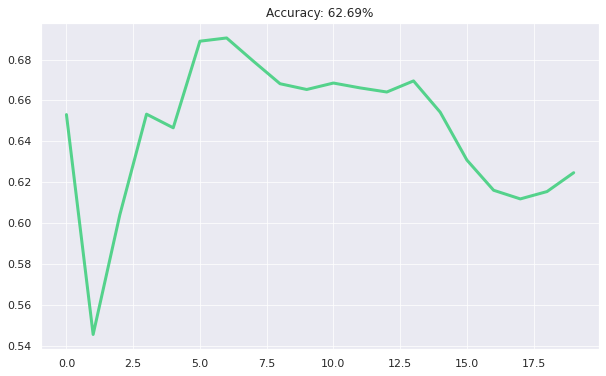

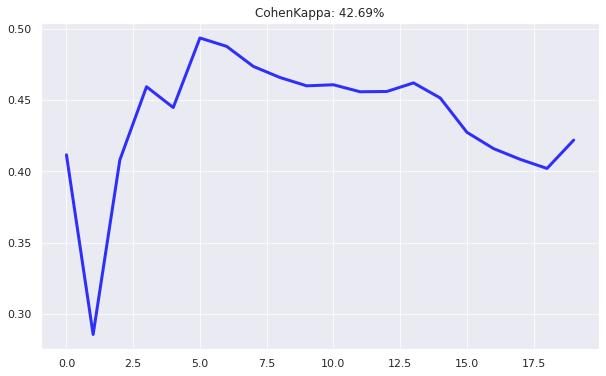

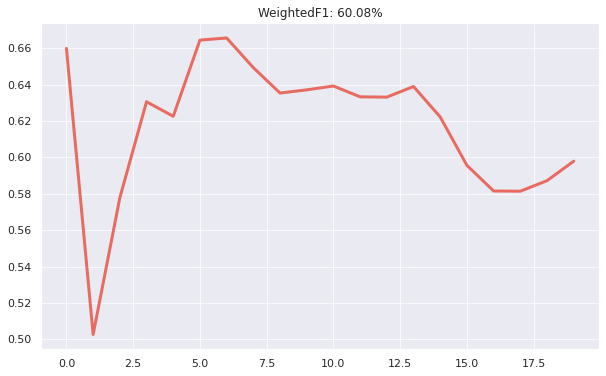

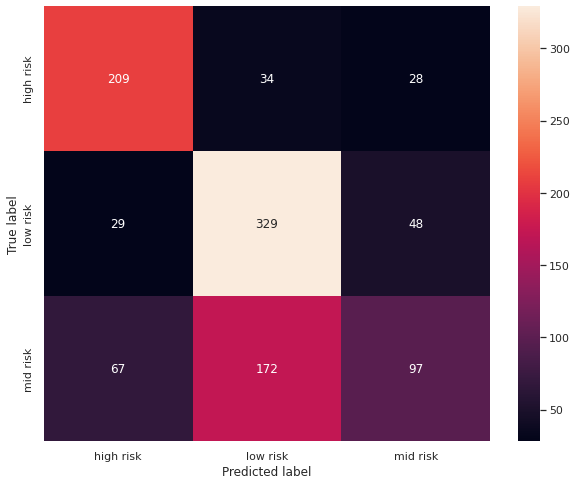

In [93]:
evaluate_binary_model(dataset, model, measure_every=50)